第14回の演習です。CNN（畳み込みニューラルネットワーク）を実装します。
左上の「ファイル」＞「ドライブにコピーを保存」を選択して、Google DriveにNotebookを保存します。ご自身のGoogleドライブの"Colab Notebooks"フォルダで、保存したNotebookを右クリックし、「アプリで開く」＞「Google Colaboratory」を選択します。その上で、各コードを実行するには、以下のコマンドを実行してください。実行は「再生」ボタンを押します。

In [1]:
print("Chapter 14")

Chapter 14


# CNN
前回、Kerasでニューラルネットワークを構築し、Fashion-MNISTデータセットのアイテム画像を認識するというタスクに対してハイパーパラメータを調整しました。その正確度（識別率）は約86%まで改善しましたが、まだ、scikit-learnライブラリのニューラルネットワークのそれには及びません。ここで、畳み込み処理とプーリング処理を導入し、CNNを構築します。

## GPUの利用
時間がかかるので、GPUを使います。Coogle Colaboratoryのメニュー「ランライム」をクリックし、「ランタイムのタイプを変更」を選択します。「ハードウェアアクセラレータ」を"GPU"に変更します。これで計算処理が多少速く終了するようになるでしょう。ただ、「Colabでの使用量上限に達したため、現在GPUに接続できません」というメッセージが出ると、GPUが割り当てられないこともあります。

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2025-06-17 23:26:05.021565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750170365.036131   73934 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750170365.041006   73934 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750170365.053530   73934 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750170365.053545   73934 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750170365.053548   73934 computation_placer.cc:177] computation placer alr

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2602031739208951143
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10747183104
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8455836802780166215
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:04:00.0, compute capability: 8.6"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 1128398848
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12199546561698963033
 physical_device_desc: "device: 1, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 2144165316]

## データセットの用意と前処理
まずはデータセットを用意し、前処理を済ませます。これらはこの回では共通の操作ですので、一度実行しておけばよいでしょう。ただし、「ランタイムリセット」されてしまったら再実行します。

In [3]:
# Fashion-MNISTデータセット
from tensorflow.keras.datasets import fashion_mnist
(train_data, train_label), (test_data, test_label) = fashion_mnist.load_data()

# Fashion-MNISTのデータ形状
print(train_data.shape)         # 学習用データ
print(train_label.shape)        # 学習用データのラベル
print(test_data.shape)          # 検証用データ
print(test_label.shape)         # 検証用データのラベル


# データの形状を確認------------------------------
import numpy as np
# データ抽出
train_data0 = train_data[0:10000, : , : ]
train_label0 = train_label[0:10000]
valid_data0 = train_data[10000:11000, : , : ]
valid_label0 = train_label[10000:11000]

# データ型
print(train_data0.dtype, valid_data0.dtype)
print(train_data0.shape, valid_data0.shape)

# uint8 -> float32（<-この下の「channelの追加」取りやめに伴う変更＠20221021）
# train_data01 = train_data0.astype("float32") / 255
train_data1 = train_data0.astype("float32") / 255
# valid_data01 = valid_data0.astype("float32") / 255
valid_data1 = valid_data0.astype("float32") / 255

# channelの追加（<-この「channelの追加」と取りやめる＠20221021）
# train_data1 = train_data01.reshape(train_data01.shape[0], train_data01.shape[1], train_data01.shape[2], 1)
# valid_data1 = valid_data01.reshape(valid_data01.shape[0], valid_data01.shape[1], valid_data01.shape[2], 1)

# データ型
print(train_data1.dtype, valid_data1.dtype)
print(train_data1.shape, valid_data1.shape)

print("学習用データ")
print(train_data1.min(), "-", train_data1.max())
print(train_label0.min(), "-", train_label0.max())
print("検証用データ")
print(valid_data1.min(), "-", valid_data1.max())
print(valid_label0.min(), "-", valid_label0.max())


# one-hotベクトルに変換----------------------
# keras.utilsからto_categoricalをインポート
from tensorflow.keras.utils import to_categorical

# ラベルの表示
print("学習用", train_label0, len(train_label0))
print("検証用", valid_label0, len(valid_label0))

# one-hot vector
train_label1 = to_categorical(train_label0)
valid_label1 = to_categorical(valid_label0)

print("学習用", train_label1, len(train_label1))
print("検証用", valid_label1, len(valid_label1))

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
uint8 uint8
(10000, 28, 28) (1000, 28, 28)
float32 float32
(10000, 28, 28) (1000, 28, 28)
学習用データ
0.0 - 1.0
0 - 9
検証用データ
0.0 - 1.0
0 - 9
学習用 [9 0 0 ... 0 6 6] 10000
検証用 [8 7 6 8 7 7 2 0 5 3 5 5 1 3 9 4 1 9 3 2 8 2 9 3 4 5 1 0 3 2 8 5 3 8 2 2 9
 7 7 9 9 1 2 6 7 6 6 6 6 7 3 7 8 5 9 5 9 1 5 9 8 3 6 1 1 0 3 3 1 2 9 8 9 5
 1 0 6 2 3 0 0 8 8 5 7 3 6 9 7 3 6 4 8 5 0 8 3 6 7 1 5 1 7 6 4 1 6 9 8 1 1
 7 7 0 7 4 9 4 2 9 9 9 6 5 2 3 5 6 5 1 9 6 1 5 6 9 3 5 3 5 3 2 7 0 9 1 1 2
 1 3 6 4 8 4 1 3 2 6 2 0 9 5 8 6 5 5 6 8 0 8 3 9 6 9 8 3 2 5 8 3 9 0 9 9 8
 1 3 8 4 9 9 0 3 0 0 6 7 8 6 6 4 6 3 9 0 4 6 7 2 5 6 2 9 7 0 2 2 3 8 4 7 6
 8 7 3 6 2 1 3 7 0 4 7 7 5 9 4 9 4 7 1 5 4 6 2 7 1 6 1 4 5 5 8 2 9 9 9 4 7
 7 5 2 0 9 1 5 0 4 9 6 8 8 3 3 6 2 6 4 5 8 0 5 2 3 4 9 2 8 5 7 4 4 0 5 3 5
 3 5 3 0 0 4 5 0 1 7 6 7 9 0 8 1 4 9 0 6 9 8 8 9 2 9 3 4 2 2 5 9 9 4 1 9 4
 4 5 1 9 2 6 1 2 5 7 3 9 9 2 2 7 1 5 0 9 6 6 4 5 4 4 1 1 6 8 0 7 9 2 3 0 8
 7 3 2 2 5 3 5 5 0 8 1 4 5 1 8 6

## 畳み込み層
畳み込み層を1つだけ追加します。入力層の後に畳み込み層を1層、挿入します。その後、Flattenを経て全結合層、そして出力層に接続するという構成になります。先ほど作った全結合層（とドロップアウト）はそのままです。まず、Conv2D()メソッドで、3×3の2次元フィルタを設定します。主な引数に以下があります。
- filters：フィルタの数
- kernel_size：フィルタのサイズ
- padding：padding = "same"でゼロパディング
- input_shape：入力データの形状（行数, 列数, チャネル）

Flatten()は畳み込み層の出力を全結合層に入力するための処理を行います。畳み込み層の出力には特徴マップ（2次元画像）とチャネル（フィルタ）が含まれますが、全結合層には1次元配列で入力します。

ネットワークの構成は以下のようになります。
- 畳み込み層（フィルタ数：32）
- 全結合層
- ドロップアウト
- 全結合層
- ドロップアウト
- 出力層（ユニット数：10）

In [11]:
#（実行には7分くらいかかります）
# ニューラルネットワークの構成----------------------------
# Neural Network
img_row = 28                # 入力層のユニット数
img_col = 28
unit_middle1 = 256          # 中間層のユニット数
unit_middle2 = 128
unit_output = 10            # 出力層のユニット数
learning_rate = 0.1         # 学習係数
epochs = 30                 # 学習を繰り返す回数（エポック数）
batch_size = 64             # ミニバッチのサイズ


# ニューラルネットワークの構築-----------------------------
# keras.modelsからSequentialをインポート
from tensorflow.keras.models import Sequential
# keras.layersからDenseとFlattenをインポート
from tensorflow.keras.layers import Dense, Flatten, Dropout     # Dropoutを追加
from tensorflow.keras.layers import Conv2D        # Conv2Dを追加
# keras.optimizersからSGDをインポート
from tensorflow.keras.optimizers import SGD

model = Sequential()

# 畳み込み層
model.add(
    Conv2D(
        filters = 32,                   # フィルタの数
        kernel_size = (3, 3),           # フィルタのサイズ
        padding = "same",               # ゼロパディング
        input_shape = (img_row, img_col, 1),      # 入力データの形状
        activation = "relu"             # 活性化関数
    ))

# (28, 28, 32) -> (25088)
model.add(Flatten())

# 中間層
model.add(Dense(unit_middle1, activation = "relu"))    # 中間層1
model.add(Dropout(0.5))                                # 中間層でドロップアウト
model.add(Dense(unit_middle2, activation = "relu"))    # 中間層2
model.add(Dropout(0.5))                                # 中間層でドロップアウト

# 出力層
model.add(Dense(unit_output, activation = "softmax"))

# モデルの概要を出力
model.summary()


# モデルのコンパイル---------------------------------
model.compile(
    optimizer = SGD(learning_rate),            # SGD
    loss = "categorical_crossentropy",         # 交差エントロピー誤差
    metrics = ["accuracy"]                     # 学習評価の指標はaccuracy
)


# 学習を実行し、結果を出力する
print(train_data1.shape, train_label1.shape)
print(valid_data1.shape, valid_label1.shape)
history = model.fit(train_data1,
                    train_label1,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1,
                    validation_data = (valid_data1, valid_label1)
)



# 検証-----------------------------------------------
# データ抽出
test_data0 = test_data[0:2000, : , : ]
test_label0 = test_label[0:2000]

# データ型
print(test_data0.dtype)
print(test_data0.shape)

# uint8 -> float32
test_data1 = test_data0.astype("float32") / 255

# データ型
print(test_data1.dtype)
print(test_data1.shape)

print("評価用データ")
print(test_data1.min(), "-", test_data1.max())
print(test_label0.min(), "-", test_label0.max())


# ラベルの表示
print("検証用", test_label0, len(test_label0))

# one-hot vector
test_label1 = to_categorical(test_label0)
print("検証用", test_label1, len(test_label1))


# 検証
score = model.evaluate(test_data1, test_label1, verbose = 1)
# 検証用データの誤り率
print("Test Loss : ", score[0])
# 検証用データの正確度
print("Test Accuracy : ", score[1])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,457,290 (24.63 MB)

 Trainable params: 6,457,290 (24.63 MB)

 Non-trainable params: 0 (0.00 B)

(10000, 28, 28) (10000, 10)
(1000, 28, 28) (1000, 10)
Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4278 - loss: 1.5504 - val_accuracy: 0.6990 - val_loss: 0.7753
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7072 - loss: 0.7846 - val_accuracy: 0.8020 - val_loss: 0.5198
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7594 - loss: 0.6465 - val_accuracy: 0.8140 - val_loss: 0.5071
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7950 - loss: 0.5676 - val_accuracy: 0.8430 - val_loss: 0.4142
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8159 - loss: 0.5030 - val_accuracy: 0.8540 - val_loss: 0.4457
Epoch 6/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8249 - loss: 0.4762 - val_accuracy: 0.8730 - val_loss: 0.3546
Epoch 7/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8445 - loss: 0.4336 - val_accuracy: 0.8880 - val_loss: 0.3445
Epoch 8/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

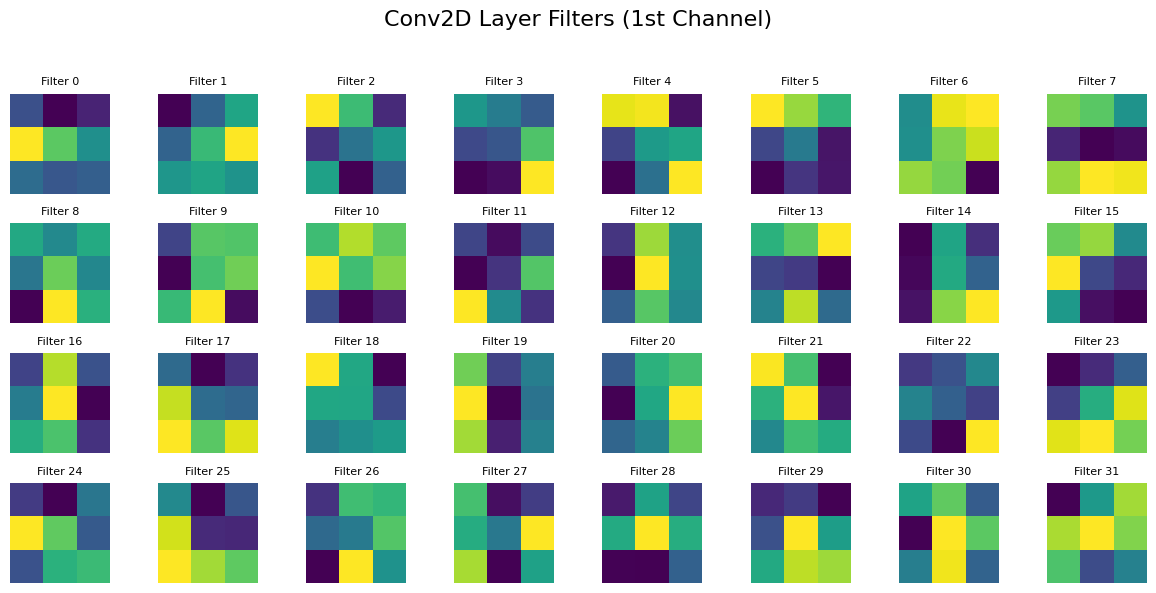

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# 畳み込み層の重みを取得
conv_layer = model.layers[0]
filters, biases = conv_layer.get_weights()

# 正規化（0～1にスケーリング）
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# フィルターを描画（8x4のグリッド表示）
n_filters = filters.shape[3]
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
axes = axes.flatten()

for i in range(n_filters):
    ax = axes[i]
    ax.imshow(filters[:, :, 0, i], cmap='viridis')
    ax.set_title(f'Filter {i}', fontsize=8)
    ax.axis('off')

plt.suptitle('Conv2D Layer Filters (1st Channel)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # タイトルと重ならないように調整
plt.show()


損失関数の値、正確度を図示します。

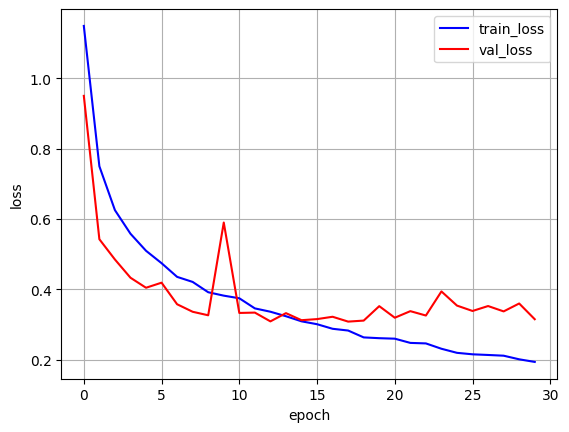

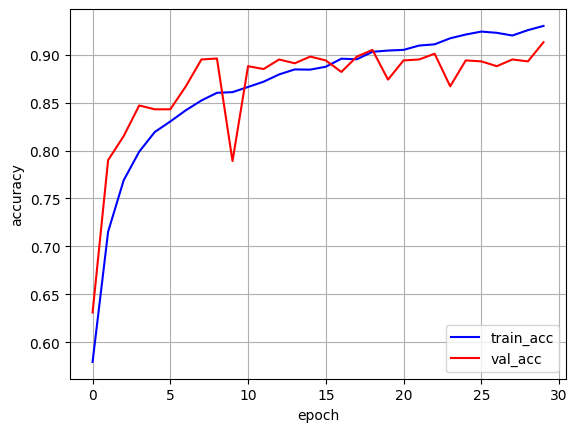

In [5]:
# Loss & Accuracy
import matplotlib.pyplot as plt

# 学習用データの損失
plt.plot(history.history["loss"],
         color = "blue",
         label = "train_loss")
# 検証用データの損失
plt.plot(history.history["val_loss"],
         color = "red",
         label = "val_loss")
plt.legend(loc = "upper right")       # 凡例
plt.grid()                            # グリッド
plt.xlabel("epoch")                   # x軸
plt.ylabel("loss")                    # y軸
plt.show()

# 学習用データの正確度
plt.plot(history.history["accuracy"],
         color = "blue",
         label = "train_acc")
# 検証用データの損失
plt.plot(history.history["val_accuracy"],
         color = "red",
         label = "val_acc")
plt.legend(loc = "lower right")       # 凡例
plt.grid()                            # グリッド
plt.xlabel("epoch")                   # x軸
plt.ylabel("accuracy")                # y軸
plt.show()

## プーリング層
プーリング層を追加します。畳み込み層の後にプーリング層を1つ挿入します。その後、Flattenを経て全結合層に接続し、出力層に接続するという構成になります。MaxPooling2D()メソッドで、2×2の領域で最大値を取り出します（最大値プーリング）。主な引数に以下があります。
- pool_size：プーリングのサイズ（最大値を取る範囲）
- strides：defaultは"None"で、pool_size（2×2なら、縦と横に2つずつずらす）

ネットワークの構成は以下のようになります。
- 畳み込み層（フィルタ数：32）
- プーリング層（最大値）
- 全結合層
- ドロップアウト
- 全結合層
- ドロップアウト
- 出力層（ユニット数：10）

In [6]:
#（実行には4分くらいかかります）
# ニューラルネットワークの構成----------------------------
# Neural Network
img_row = 28                # 入力層のユニット数
img_col = 28
unit_middle1 = 256          # 中間層のユニット数
unit_middle2 = 128
unit_output = 10            # 出力層のユニット数
learning_rate = 0.1         # 学習係数
epochs = 30                 # 学習を繰り返す回数（エポック数）
batch_size = 64             # ミニバッチのサイズ


# ニューラルネットワークの構築-----------------------------
# keras.modelsからSequentialをインポート
from tensorflow.keras.models import Sequential
# keras.layersからDenseとFlattenをインポート
from tensorflow.keras.layers import Dense, Flatten, Dropout     # Dropoutを追加
from tensorflow.keras.layers import Conv2D, MaxPooling2D        # MaxPooling2Dを追加
# keras.optimizersからSGDをインポート
from tensorflow.keras.optimizers import SGD

model = Sequential()

# 畳み込み層
model.add(
    Conv2D(
        filters = 32,                   # フィルタの数
        kernel_size = (3, 3),           # フィルタのサイズ
        padding = "same",               # ゼロパディング
        input_shape = (img_row, img_col, 1),      # 入力データの形状
        activation = "relu"             # 活性化関数
    ))

# プーリング層(14, 14, 32)
model.add(
    MaxPooling2D(pool_size = (2, 2)))   # プーリングサイズ

# (28, 28, 32) -> (25088)
model.add(Flatten())

# 中間層
model.add(Dense(unit_middle1, activation = "relu"))    # 中間層1
model.add(Dropout(0.5))                                # 中間層でドロップアウト
model.add(Dense(unit_middle2, activation = "relu"))    # 中間層2
model.add(Dropout(0.5))                                # 中間層でドロップアウト

# 出力層
model.add(Dense(unit_output, activation = "softmax"))

# モデルの概要を出力
model.summary()


# モデルのコンパイル---------------------------------
model.compile(
    optimizer = SGD(learning_rate),            # SGD
    loss = "categorical_crossentropy",         # 交差エントロピー誤差
    metrics = ["accuracy"]                     # 学習評価の指標はaccuracy
)


# 学習を実行し、結果を出力する
print(train_data1.shape, train_label1.shape)
print(valid_data1.shape, valid_label1.shape)
history = model.fit(train_data1,
                    train_label1,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1,
                    validation_data = (valid_data1, valid_label1)
)



# 検証-----------------------------------------------
# データ抽出
test_data0 = test_data[0:2000, : , : ]
test_label0 = test_label[0:2000]

# データ型
print(test_data0.dtype)
print(test_data0.shape)

# uint8 -> float32
test_data1 = test_data0.astype("float32") / 255

# データ型
print(test_data1.dtype)
print(test_data1.shape)

print("評価用データ")
print(test_data1.min(), "-", test_data1.max())
print(test_label0.min(), "-", test_label0.max())


# ラベルの表示
print("検証用", test_label0, len(test_label0))

# one-hot vector
test_label1 = to_categorical(test_label0)
print("検証用", test_label1, len(test_label1))


# 検証
score = model.evaluate(test_data1, test_label1, verbose = 1)
# 検証用データの誤り率
print("Test Loss : ", score[0])
# 検証用データの正確度
print("Test Accuracy : ", score[1])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,640,394 (6.26 MB)

 Trainable params: 1,640,394 (6.26 MB)

 Non-trainable params: 0 (0.00 B)

(10000, 28, 28) (10000, 10)
(1000, 28, 28) (1000, 10)
Epoch 1/30


2025-06-17 23:26:35.649840: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1011', 20 bytes spill stores, 20 bytes spill loads

2025-06-17 23:26:35.898765: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1011', 20 bytes spill stores, 20 bytes spill loads

2025-06-17 23:26:35.917905: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1011', 596 bytes spill stores, 512 bytes spill loads

2025-06-17 23:26:35.927736: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1011', 308 bytes spill stores, 308 bytes spill loads

2025-06-17 23:26:36.071217: I extern

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.4002 - loss: 1.6211 - val_accuracy: 0.7310 - val_loss: 0.7225
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6830 - loss: 0.8352 - val_accuracy: 0.7880 - val_loss: 0.5485
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7412 - loss: 0.6755 - val_accuracy: 0.7020 - val_loss: 0.7352
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7756 - loss: 0.6149 - val_accuracy: 0.8350 - val_loss: 0.4566
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7987 - loss: 0.5598 - val_accuracy: 0.8640 - val_loss: 0.3855
Epoch 6/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8169 - loss: 0.5199 - val_accuracy: 0.8740 - val_loss: 0.3733
Epoch 7/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8237 - loss: 0.4907 - val_accuracy: 0.7920 - val_loss: 0.5033
Epoch 8/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8469 - loss: 0.4468 - val_accuracy: 0.8750 - val

損失関数の値、正確度を図示します。

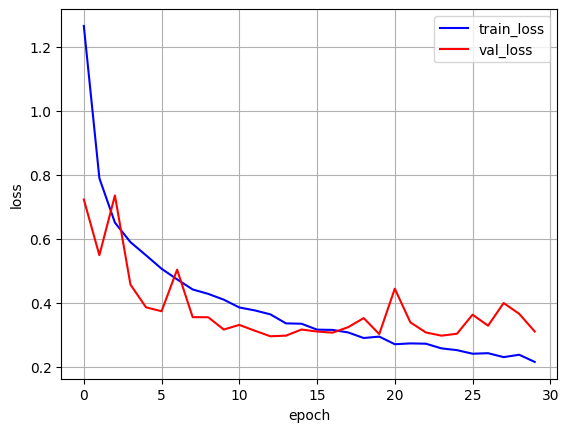

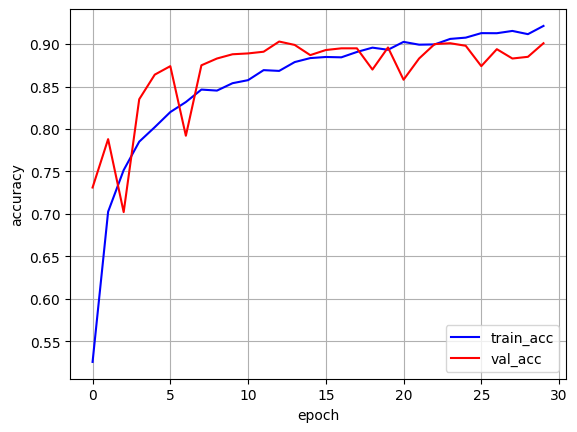

In [7]:
# Loss & Accuracy
import matplotlib.pyplot as plt

# 学習用データの損失
plt.plot(history.history["loss"],
         color = "blue",
         label = "train_loss")
# 検証用データの損失
plt.plot(history.history["val_loss"],
         color = "red",
         label = "val_loss")
plt.legend(loc = "upper right")       # 凡例
plt.grid()                            # グリッド
plt.xlabel("epoch")                   # x軸
plt.ylabel("loss")                    # y軸
plt.show()

# 学習用データの正確度
plt.plot(history.history["accuracy"],
         color = "blue",
         label = "train_acc")
# 検証用データの損失
plt.plot(history.history["val_accuracy"],
         color = "red",
         label = "val_acc")
plt.legend(loc = "lower right")       # 凡例
plt.grid()                            # グリッド
plt.xlabel("epoch")                   # x軸
plt.ylabel("accuracy")                # y軸
plt.show()

## 畳み込み層とプーリング層をもう1セット追加
畳み込み層とプーリング層をもう1セット追加してみましょう。ネットワークの構成は以下のようになります。
- 畳み込み層（フィルタ数：32）
- プーリング層（最大値）
- 畳み込み層（フィルタ数：64）
- プーリング層（最大値）
- Flatten
- 全結合層
- ドロップアウト
- 全結合層
- ドロップアウト
- 出力層（ユニット数：10）

In [8]:
#（実行には7分くらいかかります）
# ニューラルネットワークの構成----------------------------
# Neural Network
img_row = 28                # 入力層のユニット数
img_col = 28
unit_middle1 = 256          # 中間層のユニット数
unit_middle2 = 128
unit_output = 10            # 出力層のユニット数
learning_rate = 0.1         # 学習係数
epochs = 30                 # 学習を繰り返す回数（エポック数）
batch_size = 64             # ミニバッチのサイズ


# ニューラルネットワークの構築-----------------------------
# keras.modelsからSequentialをインポート
from tensorflow.keras.models import Sequential
# keras.layersからDenseとFlattenをインポート
from tensorflow.keras.layers import Dense, Flatten, Dropout     # Dropoutを追加
from tensorflow.keras.layers import Conv2D, MaxPooling2D        # MaxPooling2Dを追加
# keras.optimizersからSGDをインポート
from tensorflow.keras.optimizers import SGD

model = Sequential()

# 畳み込み層1
model.add(
    Conv2D(
        filters = 32,                   # フィルタの数
        kernel_size = (3, 3),           # フィルタのサイズ
        padding = "same",               # ゼロパディング
        input_shape = (img_row, img_col, 1),      # 入力データの形状
        activation = "relu"             # 活性化関数
    ))

# プーリング層1(14, 14, 32)
model.add(
    MaxPooling2D(pool_size = (2, 2)))   # プーリングサイズ

# 畳み込み層2
model.add(
    Conv2D(
        filters = 64,                   # フィルタの数
        kernel_size = (3, 3),           # フィルタのサイズ
        padding = "same",               # ゼロパディング
        activation = "relu"             # 活性化関数
    ))

# プーリング層2(7, 7, 64)
model.add(
    MaxPooling2D(pool_size = (2, 2)))   # プーリングサイズ


# (7, 7, 64) -> (3136)
model.add(Flatten())

# 中間層
model.add(Dense(unit_middle1, activation = "relu"))    # 中間層1
model.add(Dropout(0.5))                                # 中間層でドロップアウト
model.add(Dense(unit_middle2, activation = "relu"))    # 中間層2
model.add(Dropout(0.5))                                # 中間層でドロップアウト

# 出力層
model.add(Dense(unit_output, activation = "softmax"))

# モデルの概要を出力
model.summary()


# モデルのコンパイル---------------------------------
model.compile(
    optimizer = SGD(learning_rate),            # SGD
    loss = "categorical_crossentropy",         # 交差エントロピー誤差
    metrics = ["accuracy"]                     # 学習評価の指標はaccuracy
)


# 学習を実行し、結果を出力する
print(train_data1.shape, train_label1.shape)
print(valid_data1.shape, valid_label1.shape)
history = model.fit(train_data1,
                    train_label1,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1,
                    validation_data = (valid_data1, valid_label1)
)



# 検証-----------------------------------------------
# データ抽出
test_data0 = test_data[0:2000, : , : ]
test_label0 = test_label[0:2000]

# データ型
print(test_data0.dtype)
print(test_data0.shape)

# uint8 -> float32
test_data1 = test_data0.astype("float32") / 255

# データ型
print(test_data1.dtype)
print(test_data1.shape)

print("評価用データ")
print(test_data1.min(), "-", test_data1.max())
print(test_label0.min(), "-", test_label0.max())


# ラベルの表示
print("検証用", test_label0, len(test_label0))

# one-hot vector
test_label1 = to_categorical(test_label0)
print("検証用", test_label1, len(test_label1))


# 検証
score = model.evaluate(test_data1, test_label1, verbose = 1)
# 検証用データの誤り率
print("Test Loss : ", score[0])
# 検証用データの正確度
print("Test Accuracy : ", score[1])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 856,074 (3.27 MB)

 Trainable params: 856,074 (3.27 MB)

 Non-trainable params: 0 (0.00 B)

(10000, 28, 28) (10000, 10)
(1000, 28, 28) (1000, 10)
Epoch 1/30


2025-06-17 23:26:53.387368: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1084', 224 bytes spill stores, 224 bytes spill loads

2025-06-17 23:26:53.393215: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1084', 596 bytes spill stores, 508 bytes spill loads

2025-06-17 23:26:53.434278: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1084', 600 bytes spill stores, 524 bytes spill loads

2025-06-17 23:26:53.559810: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1084', 716 bytes spill stores, 600 bytes spill loads

2025-06-17 23:26:53.639003: I ex

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.3400 - loss: 1.7510 - val_accuracy: 0.5990 - val_loss: 0.9643
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6491 - loss: 0.9362 - val_accuracy: 0.7780 - val_loss: 0.5785
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7341 - loss: 0.7056 - val_accuracy: 0.7980 - val_loss: 0.4781
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7744 - loss: 0.5976 - val_accuracy: 0.8310 - val_loss: 0.4448
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7822 - loss: 0.5779 - val_accuracy: 0.8240 - val_loss: 0.4400
Epoch 6/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8026 - loss: 0.5284 - val_accuracy: 0.8560 - val_loss: 0.3872
Epoch 7/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8156 - loss: 0.5128 - val_accuracy: 0.8760 - val_loss: 0.3603
Epoch 8/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8417 - loss: 0.4469 - val_accuracy: 0.8770 - val

損失関数の値、正確度を図示します。

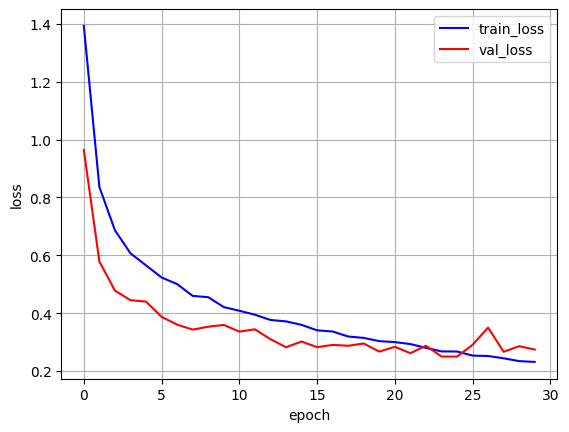

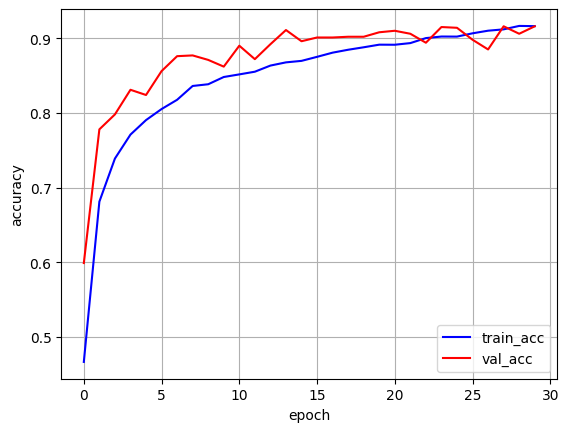

In [9]:
# Loss & Accuracy
import matplotlib.pyplot as plt

# 学習用データの損失
plt.plot(history.history["loss"],
         color = "blue",
         label = "train_loss")
# 検証用データの損失
plt.plot(history.history["val_loss"],
         color = "red",
         label = "val_loss")
plt.legend(loc = "upper right")       # 凡例
plt.grid()                            # グリッド
plt.xlabel("epoch")                   # x軸
plt.ylabel("loss")                    # y軸
plt.show()

# 学習用データの正確度
plt.plot(history.history["accuracy"],
         color = "blue",
         label = "train_acc")
# 検証用データの損失
plt.plot(history.history["val_accuracy"],
         color = "red",
         label = "val_acc")
plt.legend(loc = "lower right")       # 凡例
plt.grid()                            # グリッド
plt.xlabel("epoch")                   # x軸
plt.ylabel("accuracy")                # y軸
plt.show()